In [2]:
## Load Libraries
from openmm.app import *
from openmm import *
from openmm.unit import *
from openmm.app import PDBFile
from pdbfixer import PDBFixer

from sys import stdout
import os

# import openmmtools
import time
# import progressbar
from openmm import XmlSerializer

In [8]:
input_path_prefix = '../../docking/outputs/best_pdbs/'
input_pdb_filename = 'TUPPD1-001_61w.pdb'

output_path_prefix = './TUPPD1-001/'
os.makedirs(output_path_prefix, exist_ok=True)

In [37]:
## Set global parameters
# timestep = 4*femtosecond
timestamp = 0.004*picoseconds

## Set to run for 100ns
nsteps = 1000
niterations = 100

# nsteps = 12500 # 50 ps
# niterations = 1000 # 50 ns

## set pH to blood-equivalent
pH = 7.4

In [12]:
## Fix PDB file to repair missing hydrogens and other issues
print('Preparing PDB file...')

fixer = PDBFixer(filename=f'{input_path_prefix}{input_pdb_filename}')
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(True)
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens(pH)
# fixer.addSolvent(fixer.topology.getUnitCellDimensions())

print(f"\tSetting pH to {pH}.")

clean_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_clean.pdb')}"
PDBFile.writeFile(fixer.topology, fixer.positions, open(clean_output_path, 'w'))
print(f'\tOutput PDB File: {clean_output_path}')

Preparing PDB file...
	Output PDB File: ./TUPPD1-001/TUPPD1-001_61w_clean.pdb


In [11]:
# Set up forcefield
print("Loading forcefield...")
# forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
forcefield = ForceField('charmm36.xml', 'charmm36/water.xml')

Loading forcefield...


In [ ]:
# Set up topology
print("Setting up topology...")
pdb = PDBFile(clean_output_path)
modeller = Modeller(pdb.topology, pdb.positions)
modeller.addHydrogens(forcefield, pH=pH)

print(f"\tSetting pH to {pH}.")

In [17]:
# Add solvent
print("Adding solvent...")
modeller.addSolvent(forcefield, ionicStrength=150*millimolar, padding=1.0*nanometers) # default: tip3p

Adding solvent...


In [18]:
# Save solvated PDB
print("Writing the solvated model...")
solvated_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_solvated.pdb')}"
PDBFile.writeFile(modeller.topology, modeller.positions, open(solvated_output_path, 'w'), keepIds=True)

Writing the solvated model...


In [19]:
# Set up system
print('Creating OpenMM System...')
system = forcefield.createSystem(modeller.topology,
                                 nonbondedMethod=PME,
                                 nonbondedCutoff=1*nanometer,
                                 constraints=HBonds,
                                 hydrogenMass=4*amu)

Creating OpenMM System...


In [20]:
# Add barostat
print('Adding barostat...')
system.addForce(MonteCarloBarostat(1*bar, 300*kelvin))

Adding barostat...


9

In [21]:
# Set up integrator
print("Setting up LMI...")
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, timestep)

Setting up LMI...


In [22]:
# Serialize and save the system to an xml file
print("Seralizing the system...")
serial_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_serialized.xml')}"
with open(serial_output_path, 'w') as f:
	f.write(XmlSerializer.serialize(system))

Seralizing the system...


In [23]:
# Set up platform
print("Setting up the platform...")
platform = Platform.getPlatformByName('CUDA')
platform.setPropertyDefaultValue('Precision', 'mixed')

Setting up the platform...


In [24]:
# Set up simulation 
print("Setting up the simulation...")
simulation = Simulation(modeller.topology, system, integrator, platform)
simulation.context.setPositions(modeller.positions)

Setting up the simulation...


In [40]:
# Minimize energy
print("Minimizing energy...")
print(f'  initial : {(simulation.context.getState(getEnergy=True).getPotentialEnergy()/kilocalories_per_mole)} kcal/mol')
simulation.minimizeEnergy(tolerance=5*kilojoule/mole)
print(f'  final   : {(simulation.context.getState(getEnergy=True).getPotentialEnergy()/kilocalories_per_mole)} kcal/mol')

Minimizing energy...
  initial : -350037.5809863806 kcal/mol
  final   : -435138.6211114445 kcal/mol


In [26]:
# Save energy minimized PDB
print("Writing the minimized model...")
minimized_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_minimized.pdb')}"
positions_minimized = simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions()
PDBFile.writeFile(modeller.topology, positions_minimized, open(minimized_output_path, 'w'),  keepIds=True)

Writing the minimized model...


In [38]:
# Set up reporters for state data, checkpoint file, and trajectory 
csv_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '.csv')}"
checkpoint_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '.chk')}"
dcd_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '.dcd')}"

simulation.reporters.append(StateDataReporter(csv_output_path, nsteps,
                                              time=True, step=True, potentialEnergy=True,
                                              kineticEnergy=True, totalEnergy=True,
                                              volume=True, temperature=True))
simulation.reporters.append(CheckpointReporter(checkpoint_output_path, nsteps))
simulation.reporters.append(DCDReporter(dcd_output_path, nsteps, enforcePeriodicBox=False))

In [39]:
# Equilibrate
print('Equilibrating...')
for iteration in range(niterations):
    simulation.step(nsteps)
    state = simulation.context.getState(getPositions=True, getVelocities=True)
    # with open(serial_output_path, 'w') as outfile:
    #     state_xml = XmlSerializer.serialize(state)
    #     outfile.write(state_xml)

Equilibrating...


In [41]:
# Save equilibrated pdb
print("Writing equilbrated model...")
equilibrated_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_equilibrated.pdb')}"
positions_equilibrated = simulation.context.getState(getPositions=True, enforcePeriodicBox=False).getPositions()
PDBFile.writeFile(modeller.topology, positions_equilibrated, open(equilibrated_output_path, 'w'), keepIds=True)

print(f'  final   : {(simulation.context.getState(getEnergy=True).getPotentialEnergy()/kilocalories_per_mole)} kcal/mol')

Writing equilbrated model...
  final   : -435138.62111899257 kcal/mol


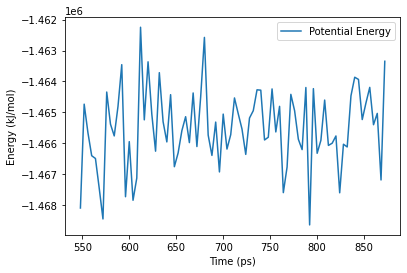

In [49]:

## Plot Results
import numpy as np
import matplotlib.pyplot as plt

## Load Data
data = np.loadtxt(csv_output_path, delimiter=',')
plot_output_path = f"{output_path_prefix}{input_pdb_filename.replace('.pdb', '_md.png')}"

step = data[:,0]
time_ps = data[:,1]
potential_energy = data[:,2]
kinetic_energy = data[:,3]
total_energy = data[:,4]
# temperature = data[:,5]
# volume = data[:,6]

## Potential Energy
plt.plot(time_ps, potential_energy, label = "Potential Energy")
# plt.plot(time_ps, kinetic_energy, label = "Kinetic Energy")
# plt.plot(time_ps, total_energy, label = "Total Energy")
plt.xlabel("Time (ps)")
plt.ylabel("Energy (kJ/mol)")
plt.legend() 
plt.savefig(plot_output_path)
plt.show()